## Loading packages

In [223]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import statistics
import math
from scipy.stats import norm
from scipy.stats import chi2

## Functions

In [31]:
def exp_weights(lamb, i, n):

    return(((lamb**(n-i))*(1-lamb)/(1-lamb**n)))

In [32]:
def LR_test(test):
    
    print(test)

In [33]:
def compute_returns(levels):
    
    returns = [0]
    
    for i in range(0, (len(levels) - 1)):
        
        returns.append((levels[i+1] - levels[i])/levels[i])
        
    return(returns)

In [30]:
def EWMA_SIGMA(df, lambdA, n_days):
    
    # Limits
    max_days = df.shape[0]
    k_assets = df.shape[1]
    
    # Select last n days
    if max_days <= n_days:
        n_days = max_days
    
    df = df.tail(n_days).copy()
    
    # Initializing SIGMA
    SIGMA = np.identity(k_assets)
    
    # Estimating covariance matrix with EWMA
    for i in range(0, n_days):
        
        r = np.matrix(df.iloc[i].values)
        
        SIGMA = lambdA * SIGMA + (1 - lambdA) * np.dot(np.transpose(r), r)
    
    return SIGMA

In [71]:
def Model_Based_Approach(df, allocation, 
                         n_days = 250, 
                         EWMA = False, 
                         lambdA = 0.94, 
                         verbose = False, 
                         quantiles = [95, 99]):
    
    # Convert quantiles to decimals
    quantiles = [quantile/100 for quantile in quantiles]
    
    # Sanity check allocation
    if len(allocation) != df.shape[1]:
        print("Each asset must be present in the allocation.")
        print("Received ", df.shape[1], " assets and ", len(allocation), " assets.")
    
    # Select last n days
    df = df.tail(n_days)
    
    # Calculate covariance matrix (simple or EWMA)
    if(EWMA):
        SIGMA = EWMA_SIGMA(df, lambdA, n_days)
    else:
        SIGMA = np.matrix(df.cov().values)
    
    # Calculate portfolio variance
    var_P = np.dot(np.dot(np.matrix(allocation), SIGMA),  np.transpose(np.matrix(allocation)))
    sd_P = math.sqrt(var_P)

    # Return 1-day VaR and 1-day ES
    VaRs = []
    ESs = []
    metrics = {}
    
    for quantile in quantiles:
        VaRs.append(sd_P * norm.ppf(quantile))
        metrics['VaR-' + str(int(quantile*100))] = sd_P * norm.ppf(quantile)   
        ESs.append(sd_P * norm.pdf(norm.ppf(quantile))/(1-quantile))
        metrics['ES-' + str(int(quantile*100))] = sd_P * norm.pdf(norm.ppf(quantile))/(1-quantile)

    # Printing results for convenience
    if verbose:
        print("--------- Analysis by the Model-based Approach --------- \n")
        print("    * Days used: ", n_days)
        print("    * EWMA: ", EWMA)
        print("    * lambda: ", lambdA if EWMA else "NaN", "\n")
        
        for key in metrics:
            
            print(key + ": " + str(metrics[key]))
    
    # Returning parameters
    return metrics
  

In [282]:
def Historical_Simulation(df, allocation, 
                         n_scenarios = 250, 
                         weighted = False, 
                         lambdA = 0.94, 
                         verbose = False, 
                         quantiles = [95, 99]):
    
    # In order to get n scenarios, we must use n + 1 days
    
    # Definition of scenario i
    # scenario_i = (v_i / v_(i-1) - 1)
    
    # Select last n days
    df = df.tail(n_scenarios).copy()
    
    if weighted:
        weights = [exp_weights(lambdA, i, n_scenarios) for i in range(1, n_scenarios + 1)]
    else:
        weights = [1/n_scenarios for i in range(0,n_scenarios)]
        
    # Calculate loss on in all scenarios
    loss = []
    
    for i in range(0, n_scenarios):
        loss.append(np.dot(df.iloc[i].values, allocation))
        
    df['Loss'] = loss
    df['Weights'] = weights

    # Sort these by the size of the loss
    df_sorted = df.sort_values(by = ['Loss'])
    
    # Scaling quantiles
    quantiles = [quantile/100 for quantile in quantiles]
    
    # Accumulate the weights to find the right percentiles
    accumulated_weights = [sum(df_sorted['Weights'].iloc[0:i]) for i in range(1, n_scenarios + 1)]
    
    df_sorted['ACC_Weights'] = accumulated_weights
    
    # Saving the result
    results = {}

    # In order to get VaR, we find the correct index
    for quantile in quantiles: 
        
        i = 0
        
        for i in range(0,n_scenarios):
            
            if df_sorted['ACC_Weights'].iloc[i] > (1-quantile):
                
                if i > 0:  
                    results['VaR-' + str(int(quantile * 100))] = -df_sorted['Loss'].iloc[i-1]
                    results['ES-' + str(int(quantile * 100))] = -np.mean(df_sorted['Loss'].iloc[0:i])
                    break
                    
                else:  
                    results['VaR-' + str(int(quantile * 100))] = -df_sorted['Loss'].iloc[0]
                    results['ES-' + str(int(quantile * 100))] = -df_sorted['Loss'].iloc[0]
                    break
                    
    return results
  

In [326]:
def Backtesting(df, allocation, n_days, VaR_level = 99, paradigme = "MBA-simple"):
    
    length = df.shape[0]
    VaR = []
    PL = []
    
    if paradigme == "MBA-simple":
        
        for i in range(n_days, length):
            
            VaR_estimates = Model_Based_Approach(df[(i-n_days):i], allocation, 
                                 n_days = n_days, 
                                 EWMA = False, 
                                 lambdA = 0.94, 
                                 verbose = False, 
                                 quantiles = [VaR_level])

            VaR.append(-VaR_estimates['VaR-' + str(VaR_level)])
            
    if paradigme == "MBA-EWMA":
        
        for i in range(n_days, length):
            
            VaR_estimates = Model_Based_Approach(df[(i-n_days):i], allocation, 
                                 n_days = n_days, 
                                 EWMA = True, 
                                 lambdA = 0.94, 
                                 verbose = False, 
                                 quantiles = [VaR_level])

            VaR.append(-VaR_estimates['VaR-' + str(VaR_level)])
            
    if paradigme == "HS-simple":
        
        for i in range(n_days, length):
            
            VaR_estimates = Historical_Simulation(df[(i-n_days):i], allocation, 
                                         n_scenarios = n_days, 
                                         weighted = False, 
                                         lambdA = 0.94, 
                                         verbose = False, 
                                         quantiles = [VaR_level])
            
            VaR.append(-VaR_estimates['VaR-' + str(VaR_level)])
            
    if paradigme == "HS-EWMA":
        
        for i in range(n_days, length):
            
            VaR_estimates = Historical_Simulation(df[(i-n_days):i], allocation, 
                                         n_scenarios = n_days, 
                                         weighted = True, 
                                         lambdA = 0.94, 
                                         verbose = False, 
                                         quantiles = [VaR_level])
            
            VaR.append(-VaR_estimates['VaR-' + str(VaR_level)])
            
    if paradigme == "HS-volatility-adjusted":
        
        for i in range(n_days, length):
            
            VaR_estimates = Historical_Simulation(df[(i-n_days):i], allocation, 
                                         n_scenarios = n_days, 
                                         weighted = False, 
                                         lambdA = 0.94, 
                                         verbose = False, 
                                         quantiles = [VaR_level])
            
            VaR.append(-VaR_estimates['VaR-' + str(VaR_level)])
            
    # Then we wish to keep track of violations
    
    violations = []

    for i in range(n_days, length):
        
        PL.append(np.dot(df.iloc[i].values, allocation))
        
    for i in range(0,len(PL)-1):
        
        if VaR[i] > PL[i+1]:
            
            violations.append(1)
            
        else:
            
            violations.append(0)
            
    # Implementation of statistical tests
    
    n_0 = len(violations)
    n_1 = sum(violations)

    pi_expected = 1 - VaR_level/100
    pi_observed = n_1/n_0
    expected_violations = pi_expected*n_0
    
    LR_uc = (pi_expected**(n_1) * (1 - pi_expected)**(n_0))/(pi_observed**(n_1) * (1 - pi_observed)**(n_0))
    chi2_statistic_1 = -2*math.log(LR_uc, math.exp(1))
    
    # Running first test
    
    significance_level = 0.05
    p_value_1 = (1 - chi2.cdf(chi2_statistic_1, 1))
    
    # Running second test
    
    n_00 = 0
    n_01 = 0
    n_10 = 0
    n_11 = 0
    
    print(violations)
    
    for i in range(1, len(violations)):
        
        print(violations[i-1], violations[i])
        
        if (violations[i-1] == 0) and (violations[i] == 0):
            n_00 += 1
        
        elif (violations[i-1] == 0) and (violations[i] == 1):
            n_01 += 1

        elif (violations[i-1] == 1) and (violations[i] == 0):
            n_10 += 1
            
        elif (violations[i-1] == 1) and (violations[i] == 1):
            n_11 += 1
            
        else:
     
            print("Something is wrong!")

    pi_01 = n_01 / (n_00 + n_01)
    pi_11 = n_11 / (n_10 + n_11)
    
    LR_ind = (pi_observed**(n_1) * (1 - pi_observed)**(n_0)) / (pi_01**n_01 * (1 - pi_01)**n_00 * pi_11**n_11 * (1 - pi_11)**n_10)
    chi2_statistic_2 = -2*math.log(LR_ind, math.exp(1))
    p_value_2 = (1 - chi2.cdf(chi2_statistic_2, 1))
    
    # Running third test
    
    chi2_statistic_3 = chi2_statistic_1 + chi2_statistic_2
    p_value_3 = (1 - chi2.cdf(chi2_statistic_3, 2))
    
    print("--------- Statistical Analysis --------- \n \n")
    print("    * Expected number of violations: ", round(expected_violations))
    print("    * Actual number of violations: ", n_1)
    print("    * n_00: ", n_00)
    print("    * n_01: ", n_01)
    print("    * n_10: ", n_10)
    print("    * n_11: ", n_11)
    print("    * Likelihood-ratio test 1: ", p_value_1)
    print("    * Likelihood-ratio test 2: ", p_value_2)
    print("    * Likelihood-ratio test 3: ", p_value_3)
   
    plt.plot(VaR)
    plt.plot(PL)
    plt.title("Figure 1: Backtesting \n")
    plt.show()
    
    return {'Observered violations': n_1, 'Expected violations': expected_violations}

    
    


In [251]:
test = Historical_Simulation(df_returns, allocation, n_scenarios = 250, weighted = True)

In [302]:
test = [1,2,3,1]

In [305]:
test[0] == 1 & test[3] == 1

True

## Importing data

In [253]:
os.chdir("/Users/andreasengly/Documents/Danmarks Tekniske Universitet/2. semester/42106 Financial Risk Management/Lecture 3 (17:02-2022)")

In [254]:
df = pd.read_csv('./Exercises/ExtendedData.csv')

## Defining Portfolio

In [256]:
Portfolio = {'DJIA': 4000000, 'FTSE': 3000000, 'CAC': 1000000, 'Nikkei': 2000000}
Total = sum([Portfolio[key] for key in Portfolio])

In [257]:
DJIA_returns = compute_returns(list(df['DJIA']))
FTSE_returns = compute_returns(list(df['FTSE']))
CAC_returns = compute_returns(list(df['CAC']))
Nikkei_returns = compute_returns(list(df['Nikkei']))

In [258]:
df['DJIA_returns'] = DJIA_returns
df['FTSE_returns'] = FTSE_returns
df['CAC_returns'] = CAC_returns
df['Nikkei_returns'] = Nikkei_returns

In [259]:
df_returns = df[['DJIA_returns', 'FTSE_returns', 'CAC_returns', 'Nikkei_returns']].copy()

## Calculating VaR and ES for 95% and 99% (Model-Based Approach)

In [260]:
allocation = np.array([4000000, 3000000, 1000000, 2000000]);

In [265]:
test = Model_Based_Approach(df_returns, allocation, n_days = 250, EWMA = True, lambdA = 0.94, verbose = True, quantiles = [90, 95, 99])

--------- Analysis by the Model-based Approach --------- 

    * Days used:  250
    * EWMA:  True
    * lambda:  0.94 

VaR-90: 79096.53706441367
ES-90: 108316.43992835983
VaR-95: 101519.3062593739
ES-95: 127309.30570313743
VaR-99: 143580.6921788568
ES-99: 164495.30477893818


## Calculating VaR and ES for 99% (Historical Simulation)

## Backtesting

In [266]:
df_returns = df_returns[1:]

In [267]:
df_returns

,DJIA_returns,FTSE_returns,CAC_returns,Nikkei_returns
1,-0.004081,-0.003142,0.000161,0.019076
2,-0.008718,0.007921,0.015374,0.011268
3,0.004351,-0.016794,-0.019105,-0.005527
4,-0.003267,0.002820,0.001156,-0.009272
5,0.000887,0.006067,0.010572,0.015706
...,...,...,...,...
2964,-0.023798,-0.011219,-0.012967,-0.003743
2965,0.008176,0.007755,0.012711,-0.010386
2966,0.004542,0.004297,0.006251,0.006677
2967,0.008369,0.001874,0.011028,-0.008731


In [299]:
True and True

True

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
1 0
0 0
0 0
0 0
0 0


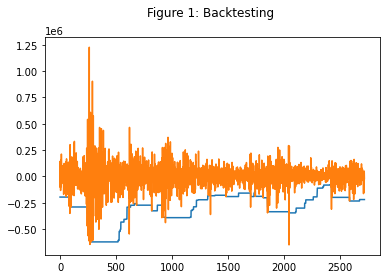

In [327]:
VaR_values = Backtesting(df_returns, allocation, 250, VaR_level = 99, paradigme = "HS-simple")

--------- Statistical Analysis --------- 
 

    * Likelihood-ratio test: As the p-value is  0.45132121048913665 , it cannot be rejected that VaR- 95  passes the backtesting.
The total number of violations is:  142


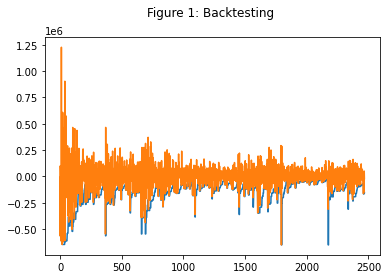

{'Observered violations': 142, 'Expected violations': 123.35000000000011}

In [284]:
Backtesting(df_returns, allocation, 500, VaR_level = 95, paradigme = "HS-EWMA")